### **Housing Prices Prediciton - Analysis Stage**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sqlite3
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error



In [2]:
#class for he db
database_name = 'house_prices.db'

# connect to the db
conn = sqlite3.connect(database_name)

train_df = pd.read_sql_query(
    "SELECT * FROM train", 
    conn)

test_df = pd.read_sql_query(
    "SELECT * FROM test", 
    conn)

# Close the connection
conn.close()

# view of data in the database
pd.set_option('display.max_columns', None)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


<Figure size 1400x800 with 0 Axes>

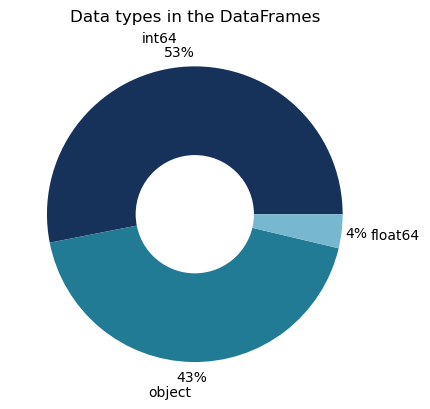

In [40]:
colors = ['#16325B', '#227B94', '#78B7D0' ,'#FFDC7F']
names = ['int64', 'object', 'float64']
datatype_chart = pd.DataFrame(train_df.dtypes.value_counts()).reset_index(names=['data_type', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(14,8))
datatype_chart.plot(kind='pie', y='count',autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
                                                  colors=colors,labels=names,legend=False
                                                  )
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf() 
fig.gca().add_artist(centre_circle)
plt.title('Data types in the DataFrames', fontsize=12)
plt.ylabel('')
plt.show()

In [ ]:
pd.set_option('display.max_rows', None)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

""


In [4]:
pd.set_option('display.max_columns', None)
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


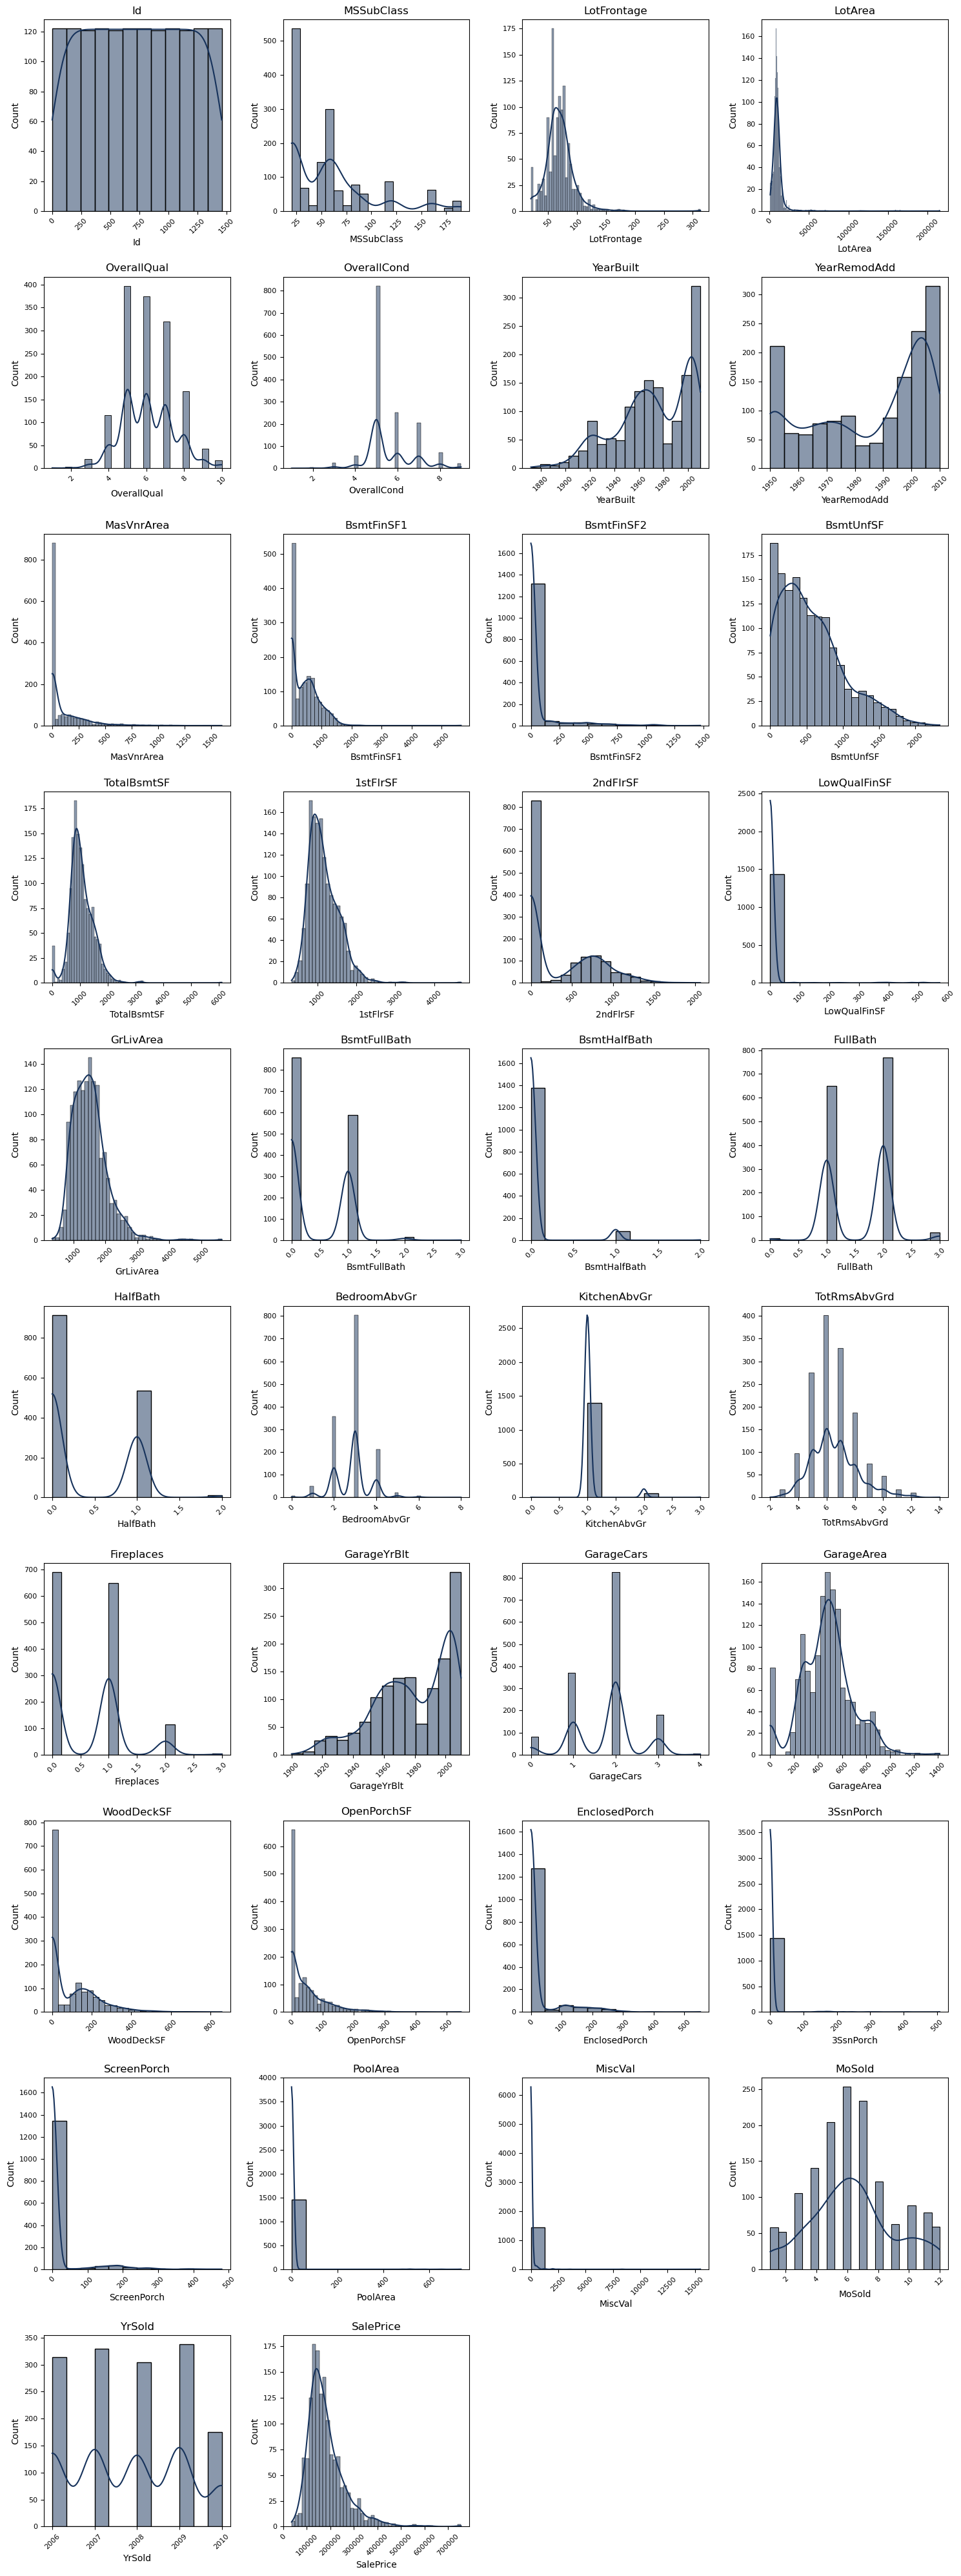

In [ ]:
numerical_cols = train_df.select_dtypes(include=['number']).columns
n_cols = len(numerical_cols)
n_rows = (n_cols + 3) // 4  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, 4, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(numerical_cols):
    
    sns.histplot(train_df[col], kde=True, ax=axes[i],color='#16325B' )
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Remov unused subplots
if n_cols < len(axes):
    for j in range(n_cols, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

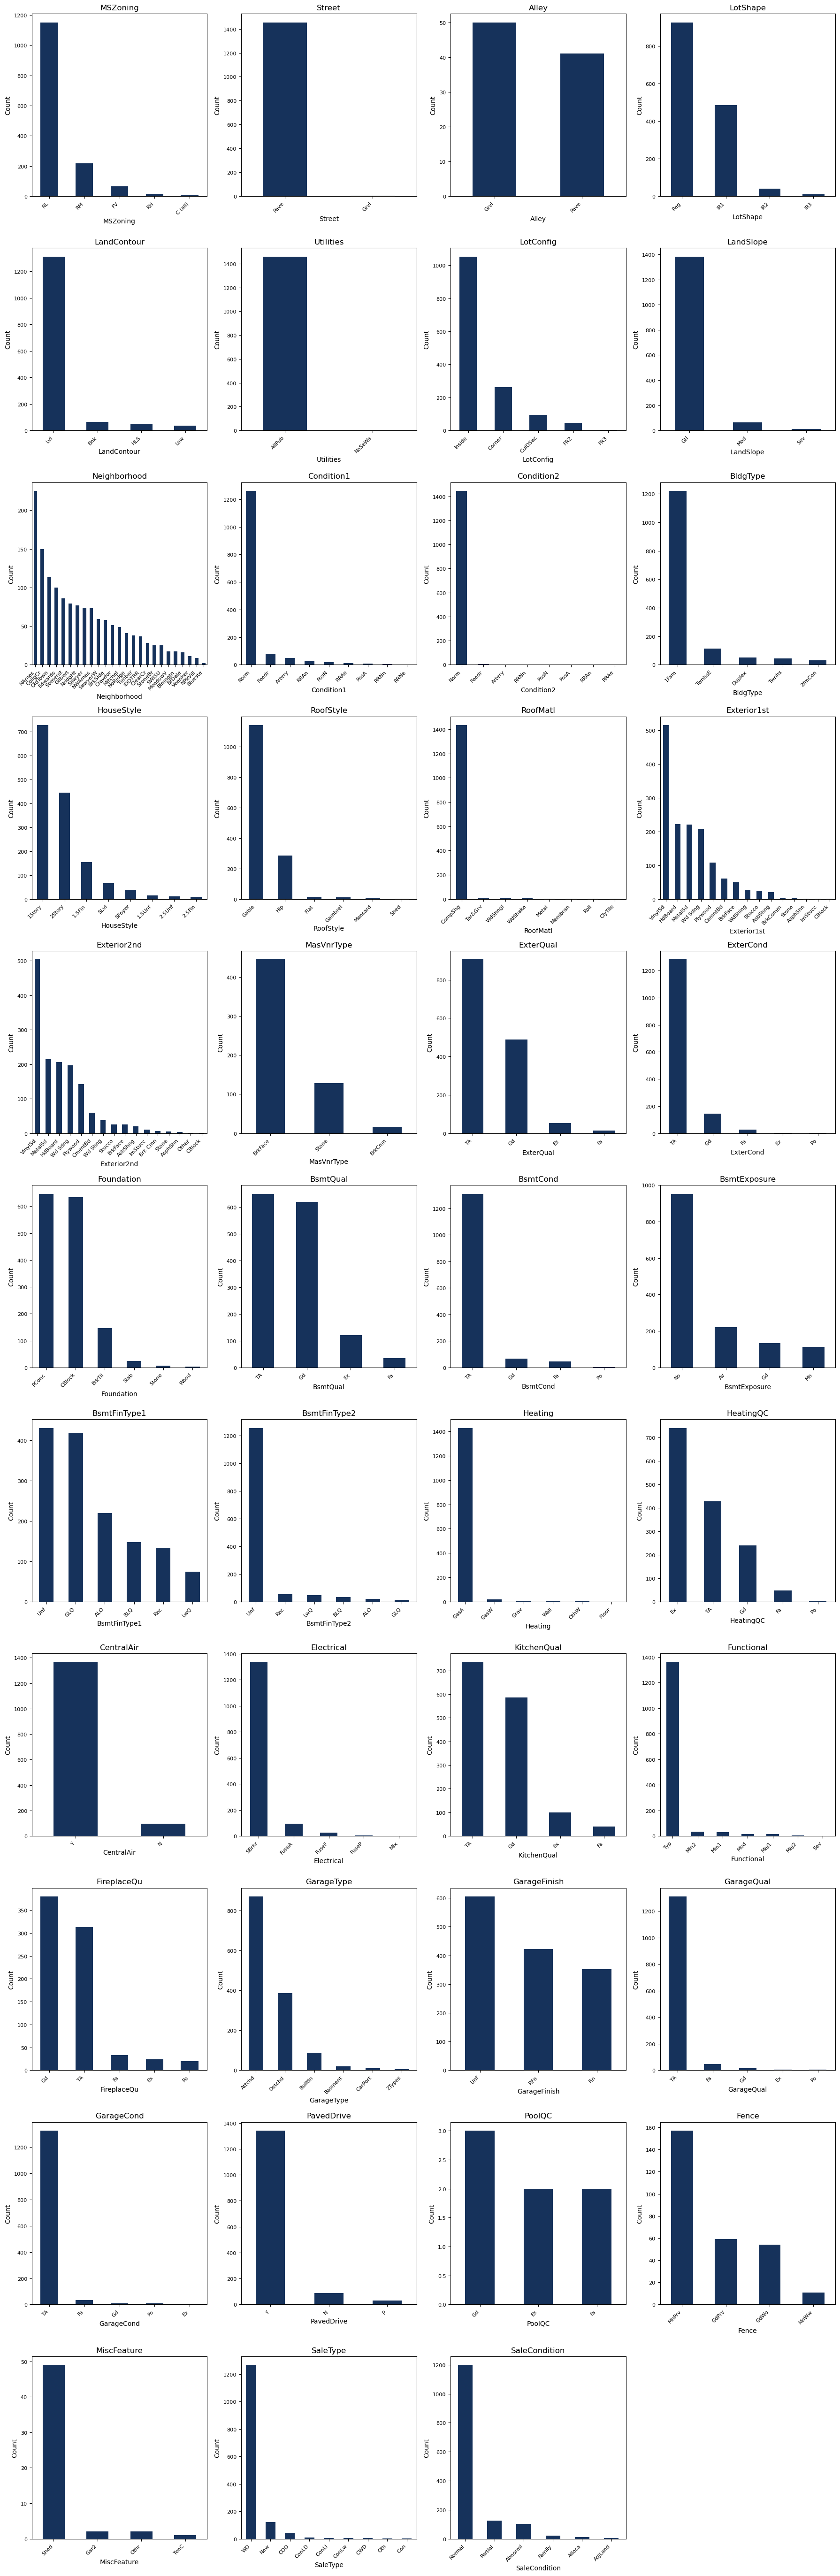

In [7]:
categorical_cols = train_df.select_dtypes(include=['object']).columns
n_cols = len(categorical_cols)
n_rows = (n_cols + 3) // 4

fig, axes = plt.subplots(n_rows, 4, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_df[col].value_counts().plot(kind='bar', ax=axes[i],color='#16325B')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right') # Ensure labels are rotated

if n_cols < len(axes):
    for j in range(n_cols, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()

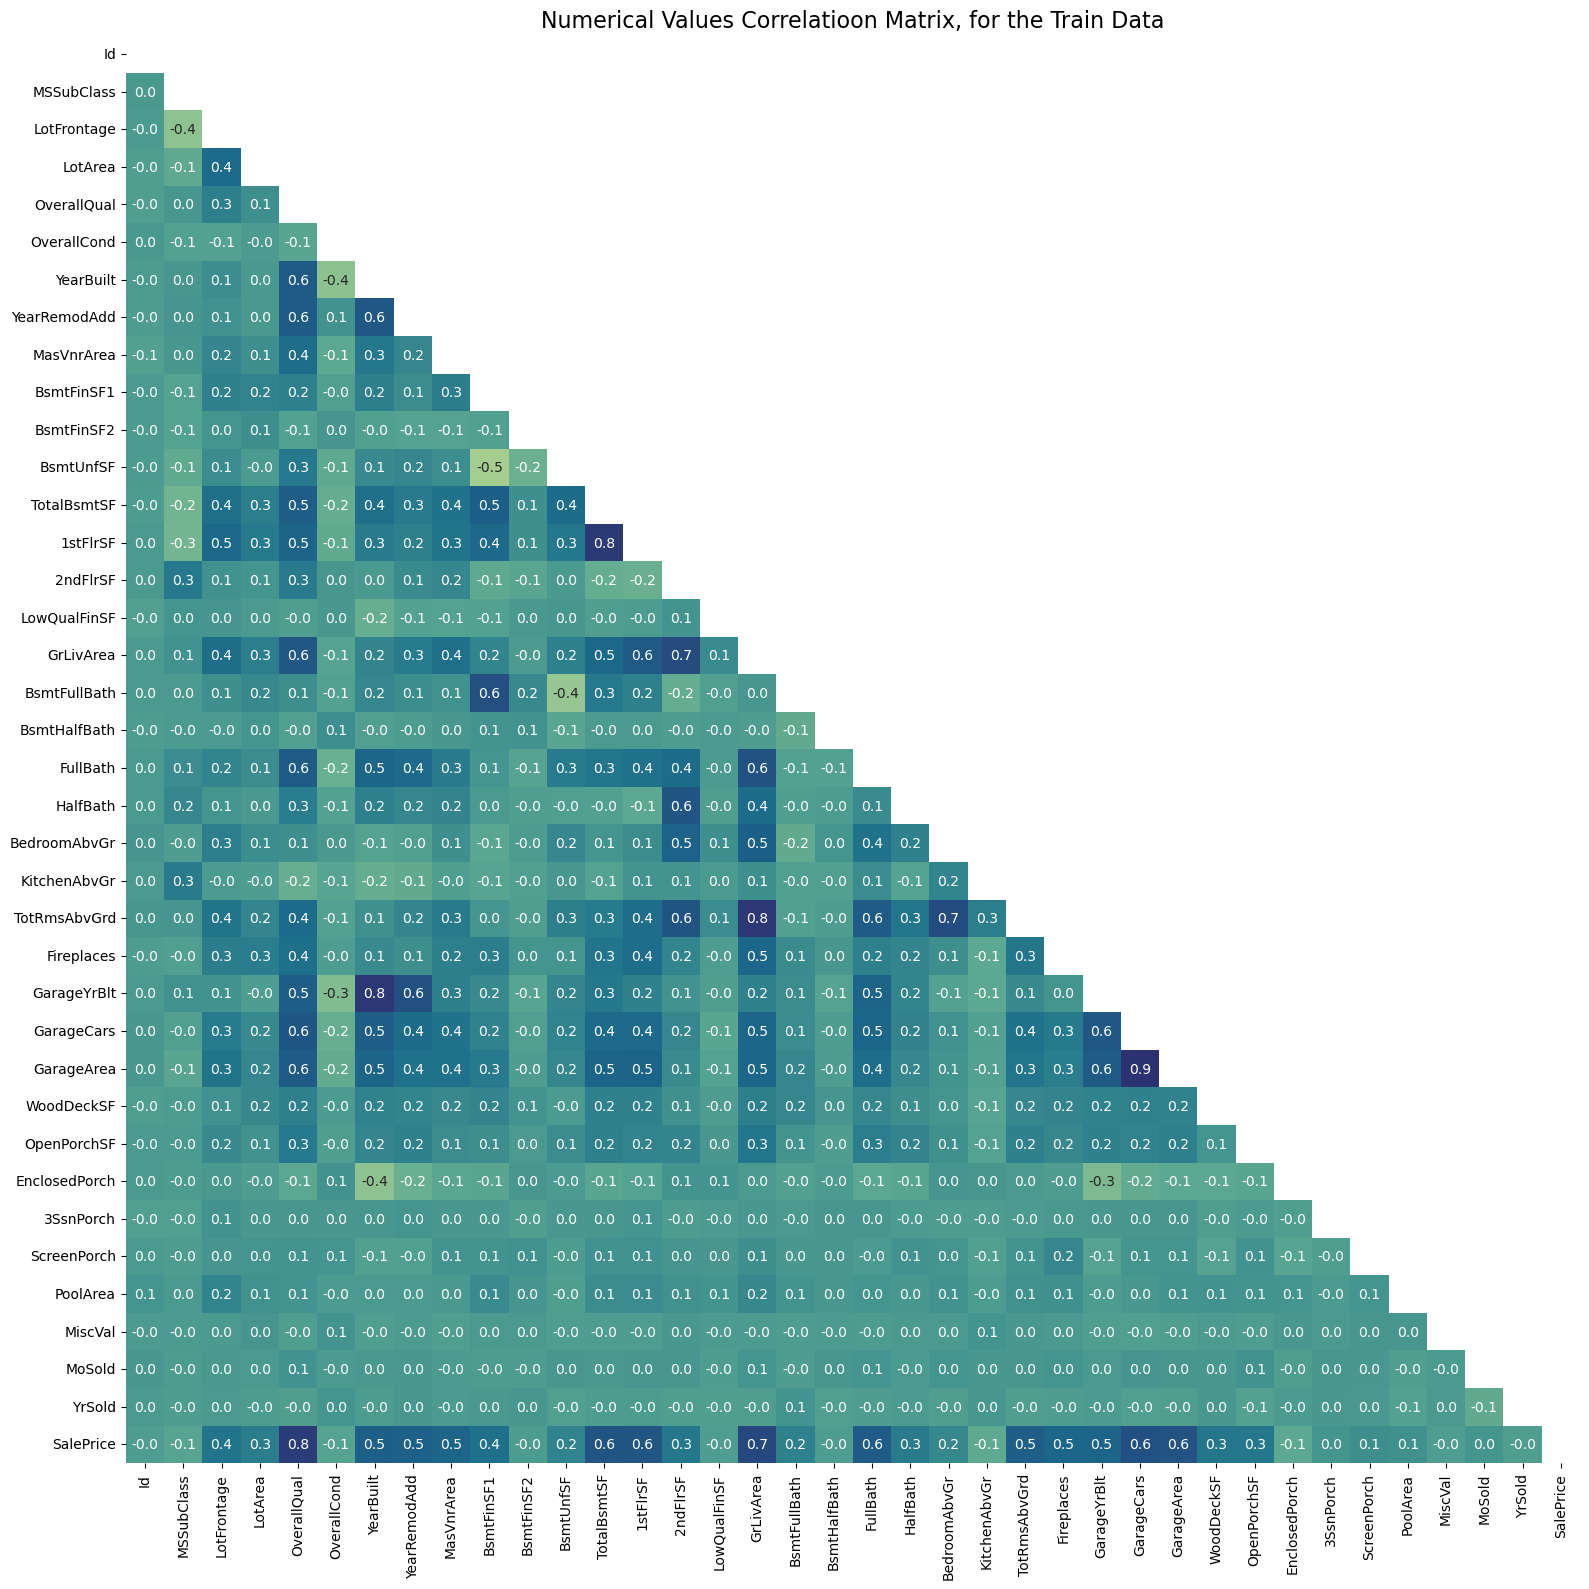

In [8]:
#numerical_cols = train_df.select_dtypes(include=['number']).columns

numerical_cols = train_df.select_dtypes(include=['number'])
corr = numerical_cols.corr()
plt.figure(figsize=(16, 16))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,cmap='crest',mask=mask,fmt='.1f',cbar=False)
plt.title('Numerical Values Correlatioon Matrix, for the Train Data', fontsize=16)
plt.tight_layout()
plt.savefig('numerical_values_correlation.png', dpi=120)
plt.show()

### Missing Values

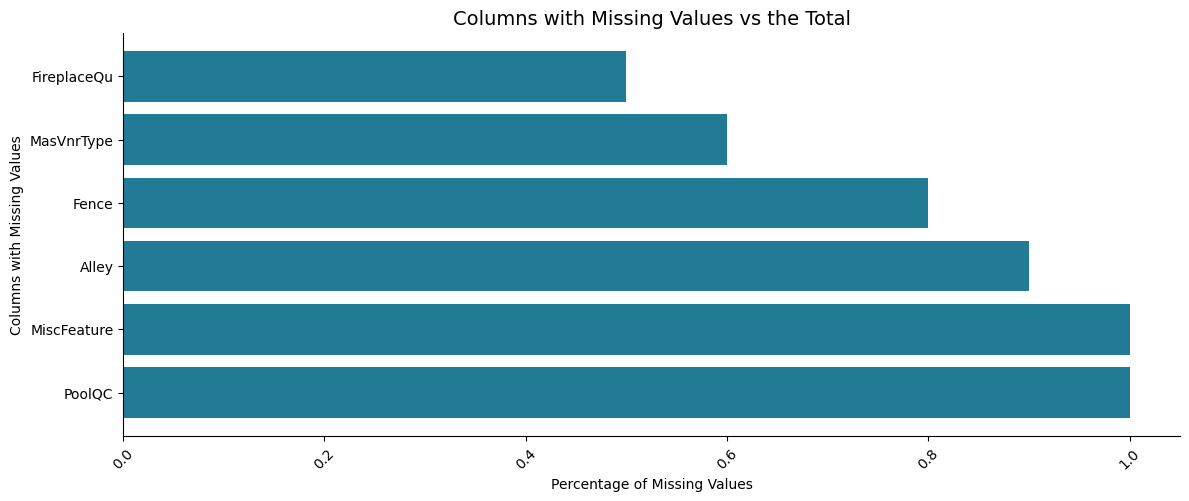

In [ ]:
cols_50perc = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column_name', 0: 'missing_count'})
cols_50perc = cols_50perc[cols_50perc['missing_count'] > 0]
cols_50perc['missing_percentage'] = cols_50perc['missing_count'] / len(train_df)
cols_50perc = round(cols_50perc[cols_50perc['missing_percentage'] * 100 > 35] ,1)


plt.figure(figsize=(12, 5))
plt.barh(cols_50perc['column_name'], cols_50perc['missing_percentage'], color='#227B94')
plt.title('Columns with Missing Values vs the Total', fontsize=14)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns with Missing Values')
plt.tight_layout()
#plt.savefig('columns_with_missing_values.png', dpi=120)
sns.despine()
plt.xticks(rotation=45)
plt.show()


Text(0.5, 1.0, 'Unique Values Distribution')

<Figure size 1200x600 with 0 Axes>

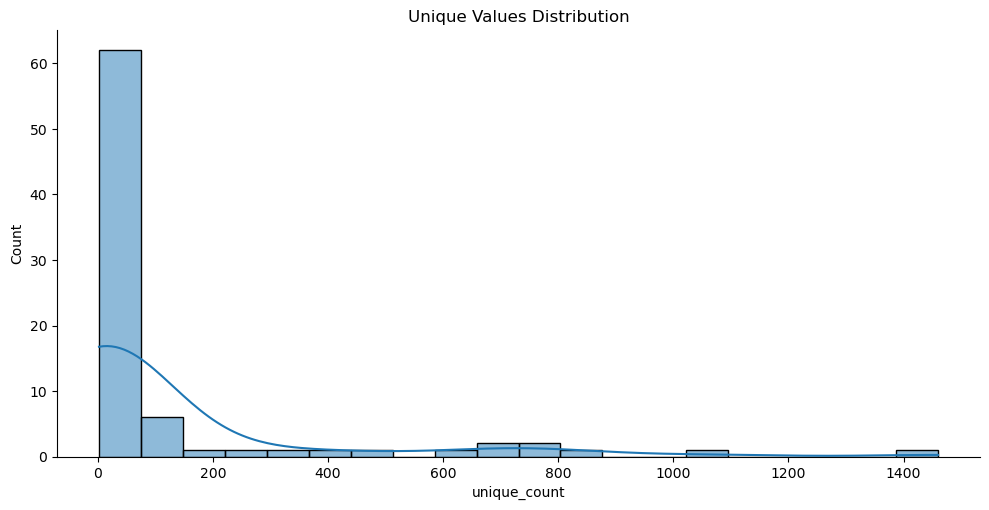

In [ ]:
unique_dist = pd.DataFrame(train_df.nunique().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column', 0: 'unique_count'})

plt.figure(figsize=(12, 6))
sns.displot(unique_dist, x='unique_count',kde=True ,bins=20, height=5, aspect=2)
plt.title('Unique Values Distribution', fontsize=12)
plt.xlabel('Unique Values Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

In [44]:
pd.DataFrame(train_df.nunique().sort_values(ascending=False)).reset_index(names=['column', 'unique_count'])

,column,0
0,Id,1460
1,LotArea,1073
2,GrLivArea,861
3,BsmtUnfSF,780
4,1stFlrSF,753
5,TotalBsmtSF,721
6,SalePrice,663
7,BsmtFinSF1,637
8,GarageArea,441
9,2ndFlrSF,417


### **Duplicate Values**

In [45]:
# check for duplicates with in our dataset 
duplicates = train_df.duplicated().sum()
print(f'There are {duplicates} duplicates in the dataset')

There are 0 duplicates in the dataset


### **Data Distribution & Skewness**

#### What is Skewnewss

Skewness is a dimensionless quantity. It doesn't have units like percentages, meters, or kilograms.

* Skewness of 0: Indicates a perfectly symmetrical distribution.
* Skewness between -0.5 and 0.5: approximately symmetric.
* Skewness between -1 and -0.5 (negative) or between 0.5 and 1 (positive): moderately skewed.
* Skewness less than -1 (negative) or greater than 1 (positive): highly skewed.

> In essence, the higher the absolute value of the skewness, the more the distribution deviates from being symmetrical. The sign tells you which way the tail is leaning.

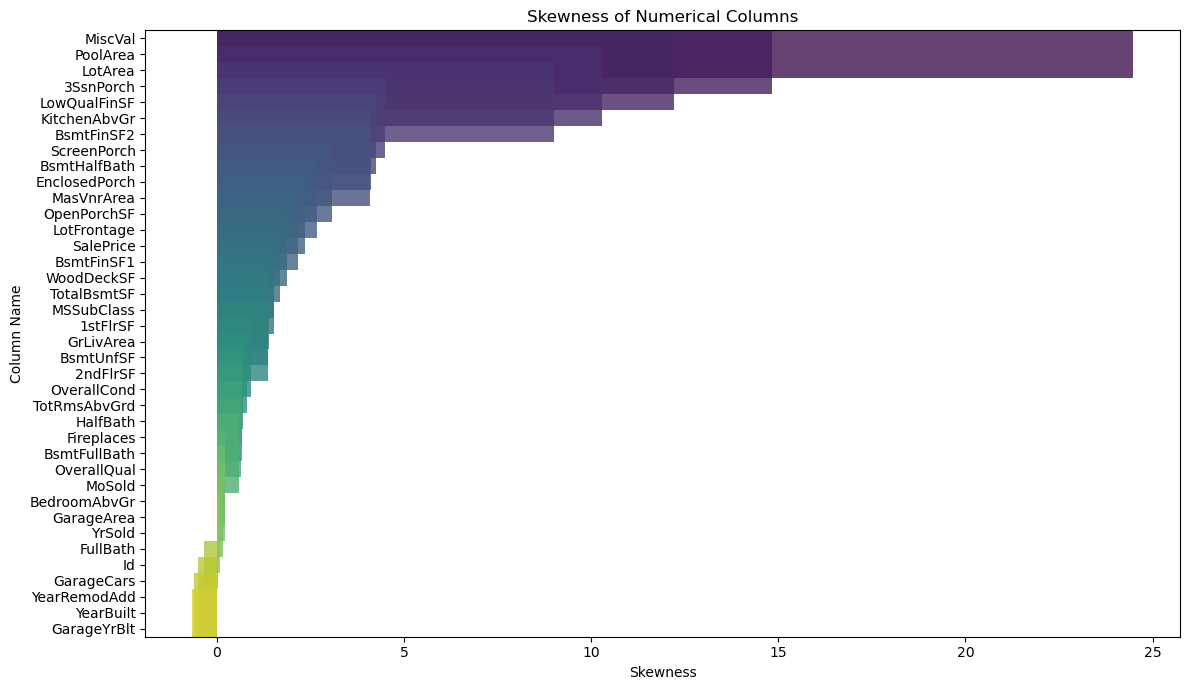

In [27]:
skew_plot = numerical_cols.skew().sort_values(ascending=False)  ##.plot(kind='bar', figsize=(12, 6), color='#227B94')

plt.figure(figsize=(12, 7))
sns.barplot(y=skew_plot.index, x=skew_plot, palette='viridis', alpha=0.8, width=5)
plt.title('Skewness of Numerical Columns', fontsize=12)
plt.xlabel('Skewness',fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.tight_layout()

In [28]:
from scipy.stats import zscore
zscore_cols = numerical_cols.apply(zscore)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,-1.730865,0.073375,NaN,-0.207142,0.651479,-0.517200,1.050994,0.878668,NaN,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.912210,-0.951226,NaN,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-1.728492,-0.872563,NaN,-0.091886,-0.071836,2.179628,0.156734,-0.429577,NaN,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,-0.318683,0.600495,NaN,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,-1.726120,0.073375,NaN,0.073480,0.651479,-0.517200,0.984752,0.830215,NaN,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.318683,0.600495,NaN,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,-1.723747,0.309859,NaN,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,NaN,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0.296763,0.600495,NaN,1.650307,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,-1.721374,0.073375,NaN,0.375148,1.374795,-0.517200,0.951632,0.733308,NaN,0.463568,-0.288653,-0.174865,0.199680,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,1.527656,0.600495,NaN,1.650307,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,NaN,-0.260560,-0.071836,-0.517200,0.918511,0.733308,NaN,-0.973018,-0.288653,0.873321,-0.238122,-0.542435,0.795198,-0.120242,0.250402,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.296763,0.600495,NaN,0.311725,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,-0.074560
1456,1.723747,-0.872563,NaN,0.266407,-0.071836,0.381743,0.222975,0.151865,NaN,0.759659,0.722112,0.049262,1.104925,2.355701,-0.795163,-0.120242,1.061367,1.107810,-0.241061,0.789741,-0.761621,0.163779,-0.211454,0.296763,2.152216,NaN,0.311725,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210,0.366161
1457,1.726120,0.309859,NaN,-0.147810,0.651479,3.078570,-1.002492,1.024029,NaN,-0.369871,-0.288653,0.701265,0.215641,0.065656,1.844744,-0.120242,1.569647,-0.819964,-0.241061,0.789741,-0.761621,1.390023,-0.211454,1.527656,2.152216,NaN,-1.026858,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210,1.077611
1458,1.728492,-0.872563,NaN,-0.080160,-0.795151,0.381743,-0.704406,0.539493,NaN,-0.865548,6.092188,-1.284176,0.046905,-0.218982,-0.795163,-0.120242,-0.832788,1.107810,-0.241061,-1.026041,-0.761621,-1.062465,-0.211454,-0.934130,-0.951226,NaN,-1.026858,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210,-0.488523


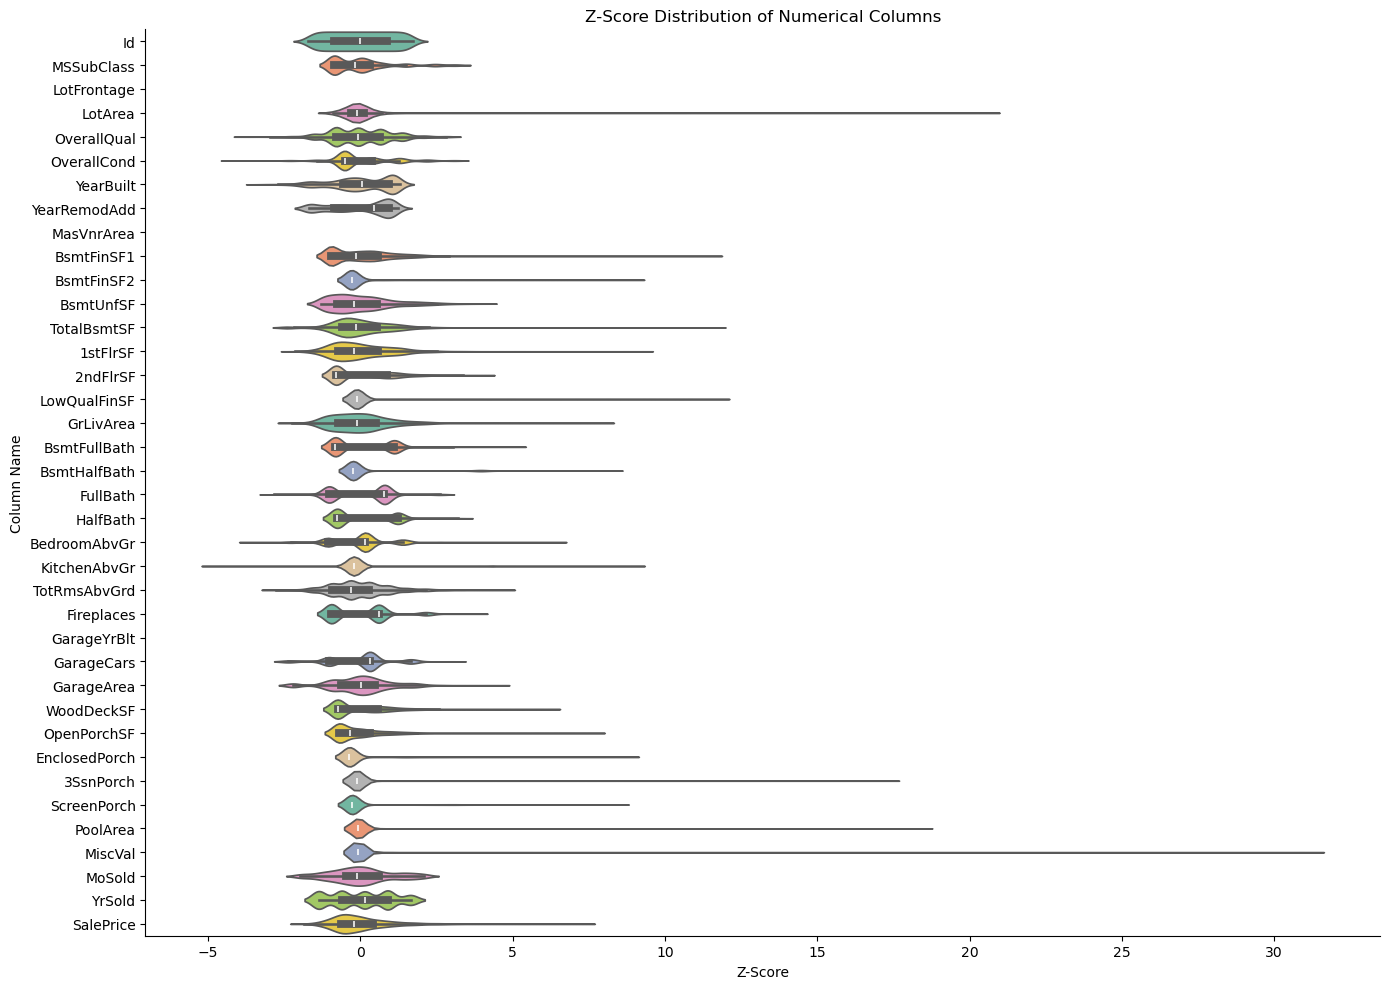

In [36]:
plt.figure(figsize=(14, 10))
ax = sns.violinplot(data=zscore_cols, orient="h", palette="Set2")
plt.title('Z-Score Distribution of Numerical Columns', fontsize=12)
plt.xlabel('Z-Score', fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.tight_layout()
sns.despine()
plt.show()

### **Looking at the Plot**:

- There are some columns with many outliers, several columns show many data points far from the central box, indicating a significant number of potential outliers based on their Z-scores. i.e include ***MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, and MiscVal.***

- There are some columns with fewer outliers: Some columns have fewer or no visible outliers, such as ***YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, MoSold, YrSold, and SalePrice. GarageYrBlt and GarageArea*** also show fewer outliers compared to the first group.


Please note all of the skewed variables(columns) need to be addressed since we're working with a regression problem a skewed or expreme values likely affect the the coefficients of regression models, potentially affectin ghte models ablility to generalize to the majority data set. However, since we are using Gradient Boosting algorithm, won't be affected by extreme values as much as distance based or some other algorithms. Nevertheless, handling the skewness of the data can only help since the extremity within the dataset can affect the performance whilst training.

 
**Handling Values**:

 - Address Skewness :- Log Transformation
 - Regularization :- Ridge

### **Sales Price**

<Figure size 1200x700 with 0 Axes>

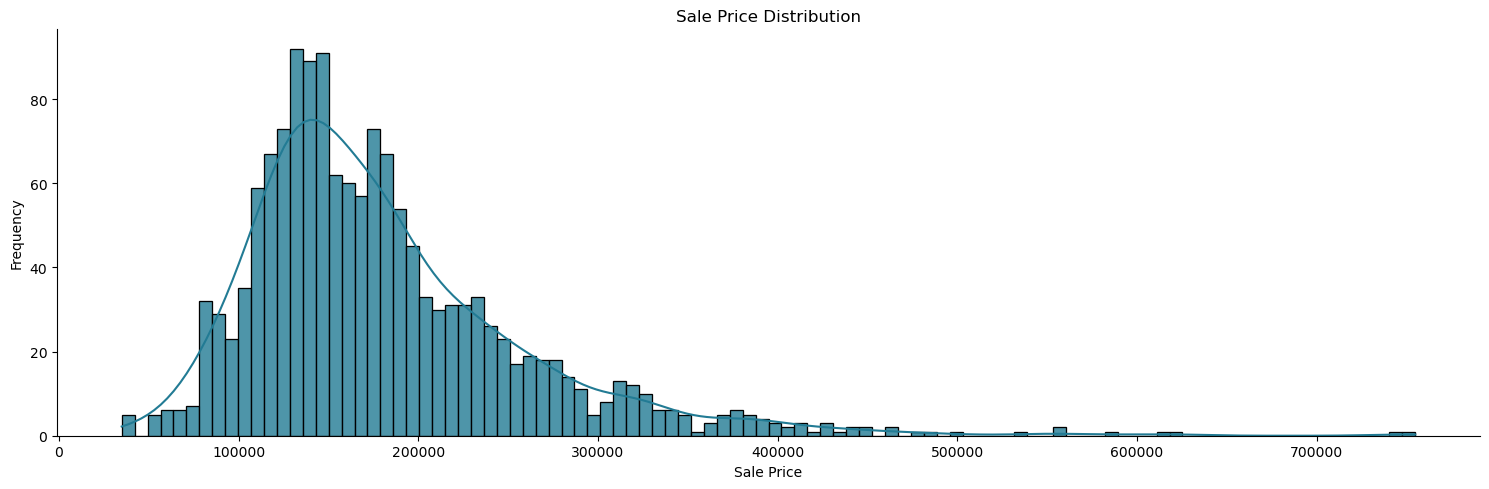

In [70]:
# figure size 
plt.figure(figsize=(12, 7))
#sns.displot(train_df['SalePrice'], kde=True, color='#227B94')
sns.displot(train_df['SalePrice'],kde=True, color='#227B94', height=5, aspect=3, bins=100, alpha=0.8) 
plt.title('Sale Price Distribution', fontsize=12)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.tight_layout()
sns.despine()
plt.show()

In [71]:
import plotly.figure_factory as ff
fig = ff.create_distplot([train_df['SalePrice']], group_labels=['Sale Price'], colors=['#227B94'],bin_size=.2)
fig.update_layout(title='Sale Price Distribution', xaxis_title='Sale Price', yaxis_title='Frequency')

In [ ]:
categorical_cols = train_df.select_dtypes(include=['object'])

## **Data Cleaning**

In [186]:
cols_50perc


,column_name,missing_count,missing_percentage
0,PoolQC,1453,1.0
1,MiscFeature,1406,1.0
2,Alley,1369,0.9
3,Fence,1179,0.8
4,MasVnrType,872,0.6
5,FireplaceQu,690,0.5


In [ ]:
def modfied_zscore(series):
    median = series.median()
    mad = np.abs(series - median).median()
    return 0.6745 * (series - median) / mad